<a href="https://colab.research.google.com/github/andreagurioli1995/CLIPasFewShotClassifier/blob/main/finetuning_BBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Transformers installation
! pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import random
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

## Reproducibility
Set variables to guarantee reproducibility

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

#Device usage
Set the device to use during training

GPU -> here refferred as 'cuda' if you have it, it's a lot faster than cpu has it's designed to parallelize the computation

CPU -> A lot slower than GPU, computes sequentially mathematical operations

In [5]:
device = "cpu"
if torch.cuda.is_available:
  print('Gpu available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

!nvidia-smi

Gpu available
Wed Nov  5 14:30:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------------

# Fine-tuning

Fine-tuning adapts a pretrained model to a specific task with a smaller specialized dataset. This approach requires far less data and compute compared to training a model from scratch, which makes it a more accessible option for many users.



This guide will show you how to fine-tune a model with [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) to classify Yelp reviews.


Start by loading the [Yelp Reviews](https://hf.co/datasets/yelp_review_full) dataset and [preprocess](https://huggingface.co/docs/transformers/main/en/./fast_tokenizers#preprocess) (tokenize, pad, and truncate) it for training. Use [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) to preprocess the entire dataset in one step.

In [6]:
dataset = load_dataset("yelp_review_full")

print(f"The original length of the training set is: {len(dataset['train'])}")
print(f"The original length of the test set is: {len(dataset['test'])}")

dataset["train"] = dataset["train"].shuffle(seed=42).select(range(1000))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(1000))

print(f"The new length of the training set is: {len(dataset['train'])}")
print(f"The new length of the test set is: {len(dataset['test'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

The original length of the training set is: 650000
The original length of the test set is: 50000
The new length of the training set is: 1000
The new length of the test set is: 1000


# What's inside my dataset?
The Yelp dataset used here consists of text reviews written by users and their corresponding numerical ratings (typically from 1 to 5 stars). Each data point pairs a user’s written opinion with their satisfaction score, forming a classic text–label dataset.

In [7]:
print(dataset["train"][0])

{'label': 4, 'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!"}


#Are we okay with it?
Our model needs a numerical input; we cannot provide them with textual input. The tokenizer maps our text to numbers associated with the original words.
These numbers will then be associated with the model's input vectors!


 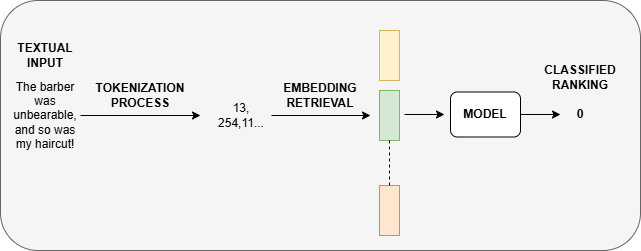


In [8]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length",return_tensors="pt", truncation=True).to(device)

dataset = dataset.map(tokenize, batched=True)
print(dataset["train"][0]['input_ids'])

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[101, 146, 27438, 1142, 4202, 119, 146, 112, 1396, 1151, 1106, 3924, 8412, 1187, 146, 9981, 1106, 1129, 170, 13395, 7589, 2288, 1107, 1413, 117, 6322, 8796, 5030, 7424, 117, 1105, 1104, 1736, 1103, 9230, 112, 188, 2319, 119, 1109, 20400, 1132, 1177, 1177, 7284, 10455, 119, 1109, 3172, 1110, 7688, 4931, 1105, 1119, 2228, 1296, 7329, 1118, 1289, 1114, 1126, 10965, 2971, 1104, 8188, 119, 1192, 13224, 3940, 1303, 3713, 106, 106, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Trainer

[Trainer](https://huggingface.co/docs/transformers/main/en/./trainer) is an optimized training loop for Transformers models, making it easy to start training right away without manually writing your own training code. Pick and choose from a wide range of training features in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) such as gradient accumulation, mixed precision, and options for reporting and logging training metrics.

Load a model and provide the number of expected labels (you can find this information on the Yelp Review [dataset card](https://huggingface.co/datasets/yelp_review_full#data-fields)).

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#Evaluation of the model before training
Let's see how the model performs before fine-tuning. The results should be completely random.

In [10]:
# Select a random element from the test dataset
random_idx = random.randint(0, len(dataset["test"]) - 1)
random_element = dataset["test"][random_idx]

# Print the text of the random element
print("Text:", random_element["text"])
#print the correct laber
print("Original correct Label:", random_element["label"])

# Get the model's prediction for the random element
outputs = model(torch.tensor(random_element['input_ids']).unsqueeze(0).to(device),
                torch.tensor(random_element['attention_mask']).unsqueeze(0).to(device))

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=-1).item()

# Print the predicted label
print("Predicted label with our fine-tuned model:", predicted_label)

Text: The problem is that the atmosphere is subpar, and the drinks are literally half full. Don't believe me order a 50/50 vesper, it's 50% full. I will not return.
Original correct Label: 1
Predicted label with our fine-tuned model: 1


> [!TIP]
> The models pretrained head is discarded and replaced with a randomly initialized classification head. The randomly initialized head needs to be fine-tuned on your specific task to output meaningful predictions.

With the model loaded, set up your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Hyperparameters are variables that control the training process - such as the learning rate, batch size, number of epochs - which in turn impacts model performance. Selecting the correct hyperparameters is important and you should experiment with them to find the best configuration for your task.

For this guide, you can use the default hyperparameters which provide a good baseline to begin with. The only settings to configure in this guide are where to save the checkpoint, how to evaluate model performance during training, and pushing the model to the Hub.

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) requires a function to compute and report your metric. For a classification task, you'll use [evaluate.load](https://huggingface.co/docs/evaluate/main/en/package_reference/loading_methods#evaluate.load) to load the [accuracy](https://hf.co/spaces/evaluate-metric/accuracy) function from the [Evaluate](https://hf.co/docs/evaluate/index) library. Gather the predictions and labels in [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy.

In [11]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Set up [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) with where to save the model and when to compute accuracy during training. The example below sets it to `"epoch"`, which reports the accuracy at the end of each epoch.
Try to change:
- Batch Size
- Learning rate

In [12]:
training_args = TrainingArguments(
    output_dir="yelp_review_classifier",
    per_device_train_batch_size = 8,
    learning_rate= 5e-05,
    eval_strategy="epoch",   # keeps validation loss each epoch
    logging_strategy="steps",
    push_to_hub=False,
    logging_first_step=True,
    report_to="none",
)

Create a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) instance and pass it the model, training arguments, training and test datasets, and evaluation function. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to start training.

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,

)
print("Showing accuracy before training")
trainer.predict(dataset["test"])

Showing accuracy before training


PredictionOutput(predictions=array([[-0.38471365,  0.9490227 , -0.00999983, -0.5814829 , -0.49867746],
       [-0.4004195 ,  0.8596684 ,  0.00316617, -0.54489505, -0.5202804 ],
       [-0.33600608,  0.9342983 , -0.03238555, -0.566989  , -0.6064253 ],
       ...,
       [-0.3399026 ,  0.85091406, -0.01646929, -0.5217617 , -0.49498224],
       [-0.3783716 ,  0.88703585, -0.01043889, -0.6569373 , -0.5364375 ],
       [-0.33180046,  0.8936384 , -0.00605075, -0.62407583, -0.49461123]],
      dtype=float32), label_ids=array([2, 4, 1, 4, 3, 4, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 3, 1, 2, 2, 1, 2,
       3, 1, 1, 3, 4, 0, 0, 2, 2, 2, 1, 3, 4, 0, 0, 1, 3, 2, 0, 2, 0, 0,
       3, 0, 3, 2, 3, 0, 1, 1, 3, 3, 4, 4, 1, 4, 1, 3, 1, 0, 0, 1, 4, 1,
       4, 3, 2, 4, 1, 0, 3, 3, 4, 1, 2, 1, 0, 4, 4, 4, 2, 3, 3, 1, 4, 0,
       4, 2, 3, 0, 0, 0, 3, 4, 0, 0, 1, 4, 4, 0, 0, 1, 1, 0, 4, 2, 2, 1,
       1, 4, 0, 4, 0, 3, 2, 0, 4, 4, 4, 2, 0, 0, 0, 1, 3, 0, 2, 0, 3, 2,
       2, 2, 0, 3, 4, 3, 0, 1, 0, 1, 0, 0, 4

Calling the train() function starts the training procedure, where weights are optimized to predict the correct ranking per review.

In [14]:
#training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,2.110100,1.276946,0.015000,0.436000
2,2.110100,1.097712,0.015000,0.507000
3,2.110100,0.987224,0.015000,0.593000


TrainOutput(global_step=375, training_loss=1.1372833124796549, metrics={'train_runtime': 375.4984, 'train_samples_per_second': 7.989, 'train_steps_per_second': 0.999, 'total_flos': 789354427392000.0, 'train_loss': 1.1372833124796549, 'epoch': 3.0})

#Final evaluation
Now our model is fine-tuned to our task. The results should not be random as before, and rankings should reflect the review text

In [15]:
# Select a random element from the test dataset
random_idx = random.randint(0, len(dataset["test"]) - 1)
random_element = dataset["test"][random_idx]

# Print the text of the random element
print("Text:", random_element["text"])
#print the correct laber
print("Original correct Label:", random_element["label"])

# Get the model's prediction for the random element
outputs = model(torch.tensor(random_element['input_ids']).unsqueeze(0).to(device),
                torch.tensor(random_element['attention_mask']).unsqueeze(0).to(device))

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=-1).item()

# Print the predicted label
print("Predicted label with our fine-tuned model:", predicted_label)

Text: Doughnuts. Donuts. Dog Nuts...whatever you call them for the most part, they're all tasty. Well maybe not dog nuts. \n\nLets get real, this place is like a fried dough time machine and I love it. Real Donuts definitely keeps it real; from the wood paneling on the walls to the $1 doughnut, it's like walking into the \"Wonder Years\" TV show. \n\nI originally came here for the inverted cinnamon rolls, but found myself buying up pretty much everything in the display case. The maple & peanut covered cinnamon rolls, cherry frosted french crullers, bear claws, the classic Simpsons doughnut (pink frosting & sprinkles), maple bars, and nearly everything in-between. \n\nNot to forgot my savory side, I also bought a jalape\u00f1o croissant stuffed with turkey, swiss cheese, and chunks of my favorite spicy pepper. This was delicious; the bread was super soft and I was told it was made fresh that morning. Sure tasted like it! This treat is a must if your taste buds like to live on the spicy 

#Try your own review!

In [21]:
my_text = "I love this place!!!"

tokenized_text = tokenizer(my_text, padding="max_length",return_tensors="pt", truncation=True).to(device)

# Get the model's prediction for the random element
outputs = model(**tokenized_text)

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=-1).item()

# Print the predicted label
print("Predicted label with our fine-tuned model:", predicted_label)

Predicted label with our fine-tuned model: 4
